# Чистка данных после парсинга ЦИАНа

In [99]:
import pandas as pd
import numpy as np

# for classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier as RFC

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns #for heatmap
plt.style.use('ggplot')

In [100]:
data = pd.read_csv('flats_CAD.csv', sep=',', header=0)
data.drop('Unnamed: 0',axis=1,inplace=True)

In [101]:
data.head()

,Bal,Brick,Dist,Floor,Kitsp,Livesp,Metrdist,New,Nfloors,Price,Rooms,Tel,Totsp,Walk,lat,lon
0,1.0,1.0,0.041516,3.0,12.1,66.8,2.0,0.0,7.0,93000000.0,3.0,0.0,142.0,1.0,55.750038,37.578460
1,1.0,1.0,0.020539,7.0,16.0,116.0,8.0,0.0,7.0,62234214.0,4.0,1.0,172.0,1.0,55.773024,37.612829
2,0.0,1.0,0.026355,3.0,NaN,NaN,9.0,0.0,7.0,81280000.0,3.0,1.0,146.3,1.0,55.744024,37.644324
3,0.0,0.0,0.057014,2.0,NaN,NaN,5.0,0.0,5.0,4814581.0,1.0,NaN,17.3,1.0,55.776294,37.672163
4,0.0,1.0,0.057014,2.0,NaN,17.3,5.0,0.0,6.0,4814581.0,1.0,0.0,17.3,1.0,55.776294,37.672163


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 16 columns):
Bal         812 non-null float64
Brick       812 non-null float64
Dist        812 non-null float64
Floor       812 non-null float64
Kitsp       460 non-null float64
Livesp      691 non-null float64
Metrdist    802 non-null float64
New         812 non-null float64
Nfloors     768 non-null float64
Price       812 non-null float64
Rooms       810 non-null float64
Tel         434 non-null float64
Totsp       812 non-null float64
Walk        802 non-null float64
lat         812 non-null float64
lon         812 non-null float64
dtypes: float64(16)
memory usage: 101.6 KB


In [103]:
col_names = data.columns

## Карта цен

Нарисуем **карту цен**, вдруг присутствуют особо дорогие районы. Видим что цены более-менее равномерные, единственные немного выделяющийся участок - в районе Хамовников.

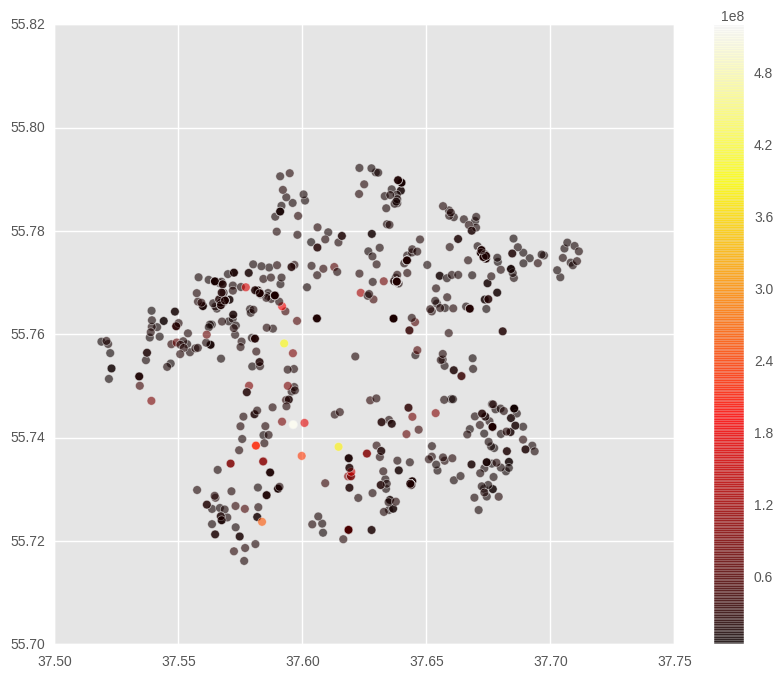

In [104]:
plt.figure(figsize = (10, 8))
plt.scatter(data.lon, data.lat, c=data.Price, cmap='hot', s=39, alpha=0.6)
plt.colorbar()
plt.show()

![](map_tsao.gif)

## Разберемся с NaN

In [105]:
data[np.isnan(data)].size

12992

Общее число неуказанных значений в таблице

In [106]:
np.sum(pd.isnull(data))

Bal           0
Brick         0
Dist          0
Floor         0
Kitsp       352
Livesp      121
Metrdist     10
New           0
Nfloors      44
Price         0
Rooms         2
Tel         378
Totsp         0
Walk         10
lat           0
lon           0
dtype: int64

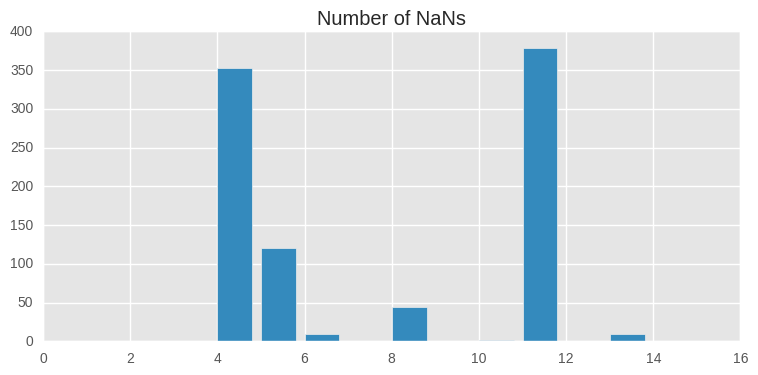

In [107]:
# bar()
plt.figure(figsize = (9, 4))
plt.bar(range(count), nans)
#plt.var(list(col_names), nans)
plt.title('Number of NaNs')
plt.grid(True)   # линии вспомогательной сетки


### Число этажей
Заполним неуказанное число этажей предсказаниями линейной модели исходя из цены квратиры, ее размера и текущего этажа

In [108]:
nfloors = LinearRegression()
nfloors.fit(data[-np.isnan(data.Nfloors)][['Floor', 'Price', 'Totsp']], 
            data.Nfloors[-np.isnan(data.Nfloors)])
nfloors_pred = nfloors.predict(data[np.isnan(data.Nfloors)][['Floor', 'Price', 'Totsp']])
data.Nfloors[np.isnan(data.Nfloors)] = nfloors_pred.astype(int)

Убедимся, что не оказалось этажа выше максимального числа и что болье нет неуказанных значений

In [109]:
data[data.Floor > data.Nfloors]

,Bal,Brick,Dist,Floor,Kitsp,Livesp,Metrdist,New,Nfloors,Price,Rooms,Tel,Totsp,Walk,lat,lon


In [110]:
len(data.Nfloors) - data.Nfloors.count()

0

### Расстояние до метро
Оценим с помощью random forest, используя координаты квартир

In [111]:
rf_Metrdist = RFC(n_estimators=10)
rf_Metrdist.fit(data[-np.isnan(data.Metrdist)][['lat', 'lon']],
               data.Metrdist[-np.isnan(data.Metrdist)])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [112]:
data.Metrdist[np.isnan(data.Metrdist)] = rf_Metrdist.predict(data[np.isnan(data.Metrdist)][['lat', 'lon']])

In [113]:
rf_Walk = RFC(n_estimators=10)
rf_Walk.fit(data[-np.isnan(data.Walk)][['lat', 'lon']],
          data.Walk[-np.isnan(data.Walk)])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [114]:
data.Walk[np.isnan(data.Walk)] = rf_Walk.predict(data[np.isnan(data.Walk)][['lat', 'lon']])

убедимся, что убрали все NaN

In [115]:
print(len(data.Walk) - data.Walk.count())
print(len(data.Metrdist) - data.Metrdist.count())

0
0


### Число комнат
Отсутствует в двух больших квартирах

In [116]:
data[np.isnan(data.Rooms)]

,Bal,Brick,Dist,Floor,Kitsp,Livesp,Metrdist,New,Nfloors,Price,Rooms,Tel,Totsp,Walk,lat,lon
532,1.0,0.0,0.016364,11.0,15.0,170.0,4.0,0.0,11.0,381025800.0,NaN,NaN,285.0,1.0,55.738216,37.614545
646,0.0,0.0,0.026699,4.0,NaN,166.7,15.0,0.0,5.0,53000000.0,NaN,1.0,265.0,1.0,55.756918,37.646318


Посмотрим на квартиры схожего размера и руками зададим число

In [117]:
data[data.Totsp>250].Rooms

114    4.0
532    NaN
589    5.0
646    NaN
730    5.0
Name: Rooms, dtype: float64

In [118]:
data.Rooms[np.isnan(data.Rooms)]=[5,5]

In [119]:
print(len(data.Rooms) - data.Rooms.count())

0


### Площадь кухни и жилая площадь
Значений пропущено довольно много, поэтому просто выкидывать данные нельзя. Предсказывать тоже трудно, но можно исходить из того, что эти параметры примерно определяются общей площадью, числом комнат, типом дома, ценой и фактом, новизной постройки.

In [120]:
col_names

Index(['Bal', 'Brick', 'Dist', 'Floor', 'Kitsp', 'Livesp', 'Metrdist', 'New',
       'Nfloors', 'Price', 'Rooms', 'Tel', 'Totsp', 'Walk', 'lat', 'lon'],
      dtype='object')

In [121]:
kitsp_mod = LinearRegression()
kitsp_mod.fit(data[-np.isnan(data.Kitsp)][['Totsp', 'Rooms', 'Price', 'Brick',  'New']],
             data.Kitsp[-np.isnan(data.Kitsp)])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [122]:
data.Kitsp[np.isnan(data.Kitsp)] = kitsp_mod.predict(data[np.isnan(data.Kitsp)][['Totsp', 'Rooms', 'Price', 'Brick',  'New']]).astype(int)

In [123]:
livesp_mod = LinearRegression()
livesp_mod.fit(data[-np.isnan(data.Livesp)][['Totsp', 'Rooms', 'Price', 'Brick',  'New']],
             data.Livesp[-np.isnan(data.Livesp)])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [124]:
data.Livesp[np.isnan(data.Livesp)] = livesp_mod.predict(data[np.isnan(data.Livesp)]
                                                      [['Totsp', 'Rooms', 'Price', 'Brick',  'New']]).round(1)

Убедимся, что не осталось незаданных значений

In [125]:
print(len(data.Kitsp) - data.Kitsp.count())
print(len(data.Livesp) - data.Livesp.count())

0
0


### Телефон 
Судя по гистограмме, только примерно в 2/3 современных домов в ЦАО установлен телефон. Поэтому нельзя просто заполнить это поле 0 или 1. Для удаления *NaN* в наличии телефона построим простейшую логистическую регрессию.

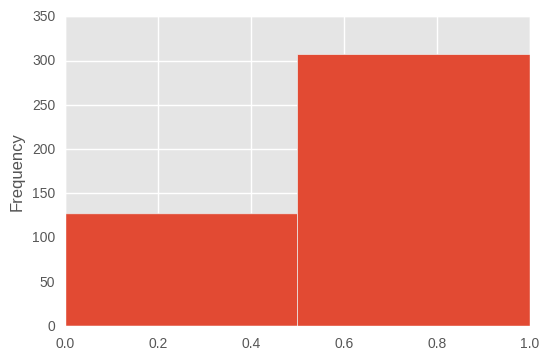

In [126]:
data.Tel.plot.hist(bins=2)

In [127]:
rf_Phone = RFC(n_estimators=10)
rf_Phone.fit(data[-np.isnan(data.Tel)].drop(['Tel'], axis=1),
          data.Tel[-np.isnan(data.Tel)])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [128]:
data.Tel[np.isnan(data.Tel)] = rf_Phone.predict(data[np.isnan(data.Tel)].drop(['Tel'], axis=1))

In [129]:
len(data.Tel) - data.Tel.count()

0

## Проверим типы данных и запишем результат в новый файл
при этом в некоторых случаях приведем типы к более оптимальным

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 16 columns):
Bal         812 non-null float64
Brick       812 non-null float64
Dist        812 non-null float64
Floor       812 non-null float64
Kitsp       812 non-null float64
Livesp      812 non-null float64
Metrdist    812 non-null float64
New         812 non-null float64
Nfloors     812 non-null float64
Price       812 non-null float64
Rooms       812 non-null float64
Tel         812 non-null float64
Totsp       812 non-null float64
Walk        812 non-null float64
lat         812 non-null float64
lon         812 non-null float64
dtypes: float64(16)
memory usage: 101.6 KB


In [131]:
data.Bal = data.Bal.astype(bool)
data.Brick = data.Brick.astype(bool)
data.Floor = data.Floor.astype(int)
data.Metrdist = data.Metrdist.astype(int)
data.New = data.New.astype(bool)
data.Nfloors = data.Nfloors.astype(int)
data.Price = data.Price.astype(int)
data.Rooms = data.Rooms.astype(int)
data.Tel = data.Tel.astype(bool)
data.Walk = data.Walk.astype(bool)

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 16 columns):
Bal         812 non-null bool
Brick       812 non-null bool
Dist        812 non-null float64
Floor       812 non-null int64
Kitsp       812 non-null float64
Livesp      812 non-null float64
Metrdist    812 non-null int64
New         812 non-null bool
Nfloors     812 non-null int64
Price       812 non-null int64
Rooms       812 non-null int64
Tel         812 non-null bool
Totsp       812 non-null float64
Walk        812 non-null bool
lat         812 non-null float64
lon         812 non-null float64
dtypes: bool(5), float64(6), int64(5)
memory usage: 73.8 KB


In [133]:
corr_matrix = np.abs(data.corr())

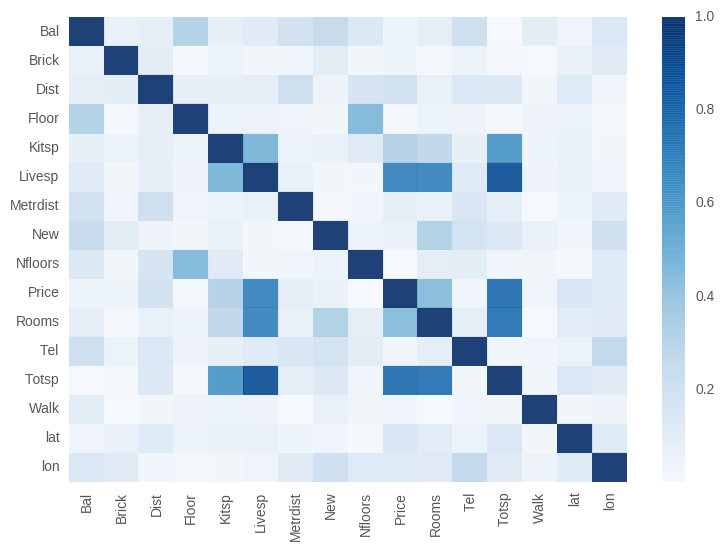

In [134]:
plt.figure(figsize = (9, 6))
sns.heatmap(corr_matrix,
            xticklabels=col_names.values,
            yticklabels=col_names.values, annot=False, 
            alpha = 0.9, cmap='Blues')

In [135]:
corr_matrix = np.asmatrix(corr_matrix)

In [136]:
corr_matrix[0,15]

0.14885191657684693

Отберем корреляции выше порогового значения

In [137]:
border = 0.5
for i in range(1,len(col_names.values)):
    for j in range(i):
        if corr_matrix[i,j] > border:
            print('corr between', col_names.values[i], 'and',  col_names.values[j], '=', corr_matrix[i,j])

corr between Price and Livesp = 0.694650354504
corr between Rooms and Livesp = 0.688870623924
corr between Totsp and Kitsp = 0.608207937649
corr between Totsp and Livesp = 0.887155568549
corr between Totsp and Price = 0.770519754117
corr between Totsp and Rooms = 0.755072439327


In [138]:
data.to_csv('Flats_handled.csv')